c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


El código se está ejecutando en la GPU: NVIDIA GeForce GTX 1050
tensor([[403.2000, 154.8800, 142.0800, 184.3200],
        [597.7600, 437.7600, 316.1600, 235.5200]])
Tiempo de inferencia: 15.807454586029053 segundos


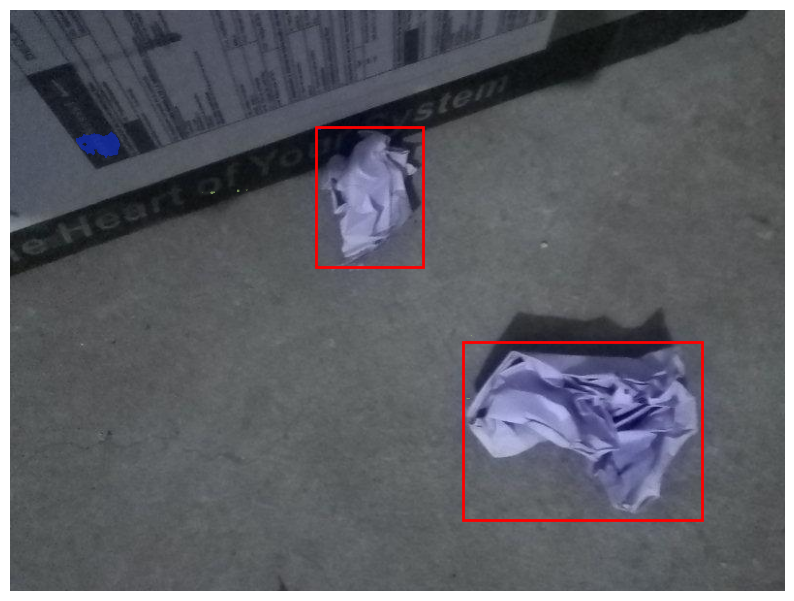

Segmentación completada para la imagen: papel (1).npy


KeyboardInterrupt: 

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import sys
import json
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch
import os
import matplotlib.patches as mpatches

# Parámetros
model_size = "small"  # small, medium, large
device = torch.device("cpu")  # cuda:0, cpu
json_file = "papelesLabels/LabelOriginal.json"  # Archivo JSON con las coordenadas de los bounding boxes

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"El código se está ejecutando en la GPU: {torch.cuda.get_device_name(current_device)}")
else:
    print("El código se está ejecutando en la CPU.")

# Estas funciones son para mostrar las máscaras, puntos y cajas
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    # x0, y0 = box[0], box[1]
    # w, h = box[2] + box[0], box[3] + box[1]
    x, y, w, h = box
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

sys.path.append("..")

# Modelos SAM disponibles a utilizar
if model_size == "small":
    sam_checkpoint = "model_checkpoint/sam_vit_b_01ec64.pth"
    model_type = "vit_b"

if model_size == "medium":
    sam_checkpoint = "model_checkpoint/sam_vit_l_0b3195.pth"
    model_type = "vit_l"

if model_size == "large":
    sam_checkpoint = "model_checkpoint/sam_vit_h_4b8939.pth"
    model_type = "vit_h"

# Cargar modelo SAM
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Utilizar el modelo SAM para predecir la máscara
predictor = SamPredictor(sam)



# crear una carpeta para almacenar los resultados
result_folder = "resultados"

os.makedirs(result_folder, exist_ok=True)
# Leer el archivo JSON
with open(json_file) as f:
    json_data = json.load(f)

for image_data in json_data:
    image_filename = image_data["annotation"]["filename"]

    # Leer imagen
    image = cv2.imread('fotos papeles basura ia2 Rodrigo Rosario/' + image_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    input_boxes = []
    object_data = image_data["annotation"]["object"]

    # Obtener las coordenadas de los bounding boxes del archivo JSON
    for obj in object_data:
        bb = obj["bndbox"]
        x = int(bb["left"])
        y = int(bb["top"])
        w = int(bb["width"])
        h = int(bb["height"])
        
        x_min = x
        y_min = y
        x_max = w
        y_max = h
    
        input_boxes.append([x_min, y_min, x_max, y_max])

    # Convertir las coordenadas de los bounding boxes en tensores de PyTorch
    input_boxes = torch.tensor(input_boxes, dtype=torch.float32).to(device=device)

    # Convertir la imagen a tensores de PyTorch
    image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device=device)

    # Predecir las máscaras con el modelo SAM
    start_time = time.time()
    # masks = predictor.predict_masks(image_tensor, input_boxes)

    predictor.set_image(image)
    # predict mask
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    print(transformed_boxes)
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    end_time = time.time()
    print(f"Tiempo de inferencia: {end_time - start_time} segundos")

    # Mostrar resultados de la imagen con su máscara y bounding box
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
    for box in input_boxes:
        show_box(box.cpu().numpy(), plt.gca())
    plt.axis('off')
    plt.show()

    # Leer la imagen segmentada
    segmented_image_path = "fotos papeles basura ia2 Rodrigo Rosario/" + image_filename
    segmented_image = cv2.imread(segmented_image_path)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

    # Normalizar la imagen
    segmented_image_normalized = segmented_image.astype(np.float32) / 255.0

    # Generar nombres de archivo únicos para la imagen y las máscaras
    image_filename = image_filename.replace(".jpg", ".npy")
    mask_filenames = [f"mascara_segmentada_{i}.npy" for i in range(len(masks))]

    # Guardar la imagen normalizada en formato .npy
    segmented_image_normalized_path = os.path.join("resultados", image_filename)
    np.save(segmented_image_normalized_path, segmented_image_normalized)

    # Crear una lista para almacenar las máscaras
    masks_list = []

    # Guardar las máscaras en formato .npy y agregarlas a la lista sin normalizar
    for i, mask in enumerate(masks):
        mask_image = (mask.cpu().numpy() * 255).astype(np.uint8)
        mask_path = os.path.join("resultados", mask_filenames[i])
        np.save(mask_path, mask_image)
        masks_list.append(mask_image)

    segmentation_masks = []
    for i in range(len(masks_list)):
        segmentation_masks.append(np.load(os.path.join("resultados", mask_filenames[i])))
    # Agregar aquí más máscaras si es necesario

    # Crear una máscara combinada inicializada con ceros
    combined_mask = np.zeros_like(segmentation_masks[0])

    # Asignar valores específicos a cada tipo de segmentación
    for i, mask in enumerate(segmentation_masks):
        combined_mask[mask > 0] = i  # Asignar el valor 'i' a los píxeles segmentados en la máscara 'mask'

    # Asignar el valor para el fondo en la máscara combinada
    background_mask = np.all(combined_mask == 0, axis=0)
    combined_mask[:, background_mask] = len(segmentation_masks)  # Asignar el valor '-1' al fondo

    combined_mask = combined_mask.squeeze()  # Eliminar dimensiones adicionales

    # guardar la máscara combinada
    combined_mask_path = os.path.join(result_folder, f"mascara_combinada_{image_filename}")
    np.save(combined_mask_path, combined_mask)

    print("Segmentación completada para la imagen:", image_filename)

print("Proceso de segmentación finalizado.")



(529, 700, 3)
(529, 700)


(-0.5, 699.5, 528.5, -0.5)

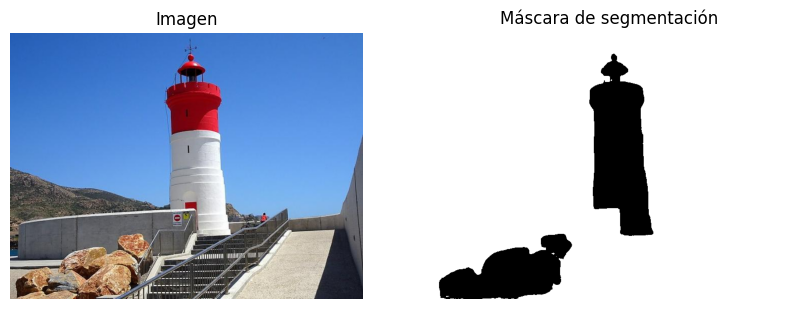

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2

# # Cargar la imagen segmentada y su máscara
# segmented_image = np.load("resultados/imagen_segmentada.npy")
# print(segmented_image.shape)
# mask_image = np.load("resultados/combined_mask.npy")
# print(mask_image.shape)


# mask_image = cv2.resize(mask_image, (segmented_image.shape[1], segmented_image.shape[0]))

# # Mostrar la imagen segmentada y su máscara
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(segmented_image)
# axs[0].set_title("Imagen")
# axs[0].axis("off")
# axs[1].imshow(mask_image, cmap="gray")
# axs[1].set_title("Máscara de segmentación")
# axs[1].axis("off")

# plt.show()


